# Image Processing Assignment

Michael Gabler - michael.gabler@etu.u-bordeaux.fr

This assignment will show how to segment an image using methods from the Image Processing course and the opencv implementation for Python. The goal is to load a stereoscopic image and generate a filter for it where every object of the picture is filled with a different color. This filter could be used to extract the objects of the original image.

## Load libraries

First of all it's necessary to load all required libraries like numpy, opencv and matplotlib. Since images are represented as matrices or multi-dimensional arrays numpy can help to manipulate them using basic mathematical operations. For more complex image processing opencv is a good choice. It's a library that contains many pre-programmed algorithms for various purposes in the field of computer vision and is therefore useful for this project. With matplotlib it's possible to easily display an image visually to show the current progress.

All other functions and classes that are used in this assignment were put to another python file to make the code in this documentation easier to read. The code can be found in `ipl.py` where there's additional documentation in form of code comments, too.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import ipl

# container to collect all produced images to display them in the end
results = ipl.ImageDisplay()

## Load images

In this section the image that needs to be processed is loaded. All the methods are applied to a photo that shows an outdoor scene with a cat on a wall and a bench in the background. The task is to build a filter image that colors the areas for the cat and the bench. Since the photo was taken with a stereoscopic camera there are two pictures which slightly different viewing angles. The function `load_images` returns the pictures `imgL` and `imgR` that correspond to the left and right camera or to the two eyes when considering a human observer.

Both images are loaded with the rgb color scheme and have the shape `(1000, 1486, 3)` which corresponds to a picture with 1486 x 1000 pixels with 3 color channels for each pixel. They are also converted to obtain a grayscale representation since this is needed for further processing.

imgL shape: (1000, 1486, 3)
imgR shape: (1000, 1486, 3)


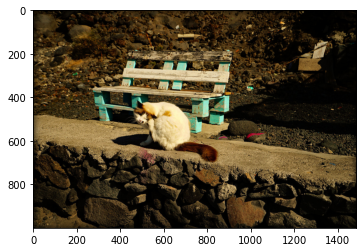

In [2]:
imgL, imgR = ipl.load_images()

print('imgL shape:', np.shape(imgL))
print('imgR shape:', np.shape(imgR))

# produce gray-scale copies of the images
imgL_gray = cv.cvtColor(imgL, cv.COLOR_RGB2GRAY)
imgR_gray = cv.cvtColor(imgR, cv.COLOR_RGB2GRAY)

results.add_image(imgL, 'original', 'viridis')
plt.imshow(imgL)
plt.show()

## Build dept map

The next step is to build a dept map with the stereoscopic image. Since the same scene is captured from two different viewing angles it is possible to calculate the distance between a pixel from each image that refers to the same point in the scene. Because of the camera setting pixels that are closer to the camera should have a bigger distance than pixels that are more in the background. The used algorithm takes the grayscale representation of the loaded images and tries to find matching pixels to calculate their distances. The result is a grayscale image of the same shape as the input with pixel values that describe the dept of the pixel. The higher the value the higher is the pixel's distance from the camera which means that the distance between the corresponding pixels in `imgL` and `imgR` is small.

After the dept map is generated its values are mapped to a range between 0 and 255 so that they can be saved as 8 bit unsigned integer values. Unfortunately the algorithm produces some noise due to incorrect pixel mappings which can be reduced by applying a low-pass filter like the median blur used in this example.

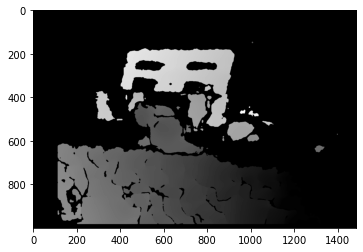

In [3]:
dept_map = ipl.build_dept_map(imgL_gray, imgR_gray)

# norm the dept map values to 255 (unsigned int)
dept_map = dept_map + np.absolute(np.amin(dept_map))
dept_map = np.uint8(dept_map / np.amax(dept_map) * 255)

# reduce noise with low-pass filter
dept_map = cv.medianBlur(dept_map, 7)

results.add_image(dept_map, 'dept map')
plt.imshow(dept_map, 'gray')
plt.show()

## Create final filter image

The final segmentation image is constructed by the class `ImageSegmentation` which initially creates an empty picture with the same shape as the original image and fills it with blue color. As the segmentation masks are built they can be added using a different color.

In [4]:
final_segmentation = ipl.ImageSegmentation(imgL)

## Segment cat

There are multiple ways to extract an area from an image. In this example the cat is extracted using the dept map and color thresholding. First of all the dept map is filtered to gain all pixels that have the same distance to the camera as the cat. This results in a filter that also selects some pixels of the wall since they have the same distance and which are considered as noise. To reduce the amount of noise a second filter is built that uses color thresholding to get all pixels of the wall. Since the colors of the wall and the cat are very different the second filter doesn't contain pixels of the cat. The second filter can now be substracted from the first one by inverting it and using the bitwise *and* operation which results in a mask for the cat with less noise.

To make the masks more precise the erode and dilation methods are used which make the selected areas smaller at first and enlarge them in the second step again to get the original size. During that process small noisy areas disappear. If they are used in reversed order they can help to fill gaps between larger areas.

The cat mask is added to the `final_segmentation` using red color. The displayed image shows the original picture with the applied cat mask.

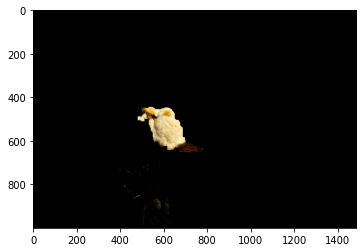

In [5]:
# threshold on dept map
ret, cat_filter1 = cv.threshold(
    dept_map, 100, 255, cv.THRESH_TOZERO_INV)
ret, cat_filter1 = cv.threshold(
    cat_filter1, 75, 255, cv.THRESH_BINARY)

# color threshold on the image to select the wall
cat_filter2 = cv.inRange(imgL, np.array(
    [30, 30, 30]), np.array([150, 150, 80]))
cat_filter2 = ipl.dilation_erode(cat_filter2, 15)

# substract filter 2 from filter 1
cat_filter2 = cv.bitwise_not(cat_filter2)
cat_filter = cv.bitwise_and(cat_filter1, cat_filter2)
cat_filter = ipl.erode_dilation(cat_filter)
cat_filter = ipl.dilation_erode(cat_filter, 20)

results.add_image(cat_filter, 'cat filter')
final_segmentation.add_mask(cat_filter, [255, 0, 0])
plt.imshow(final_segmentation.apply_mask(cat_filter))
plt.show()

## Segment bench

After building a mask for the cat the next object to extract from the picture is the bench in the background. Since there are no other objects in the picture that have the same distance to the camera it is sufficient to just use the dept map again and select all the pixels with the bench's distance.

The resulting mask is also added to the `final_segmentation` using green color and the displayed image shows the selected area of the original image.

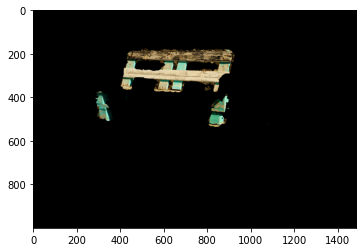

In [6]:
# threshold on dept map
ret, bench_filter = cv.threshold(
    dept_map, 230, 255, cv.THRESH_TOZERO_INV)
ret, bench_filter = cv.threshold(
    bench_filter, 190, 255, cv.THRESH_BINARY)

results.add_image(bench_filter, 'bench filter')
final_segmentation.add_mask(bench_filter, [0, 255, 0])
plt.imshow(final_segmentation.apply_mask(bench_filter))
plt.show()

## Display results

This section shows the produced masks together with the original image. The last output is the final segmentation which shows the cat in red, the bench in green and the blue background.

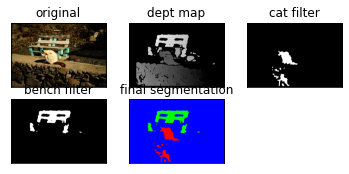

In [7]:
# add the final segmentation to results
results.add_image(final_segmentation.get_filter(), 'final segmentation', 'viridis')

# show all saved images
results.show()